In [9]:
import pandas as pd
import numpy as np
import locale
locale.setlocale( locale.LC_ALL, '' )

'English_United States.1252'

In [10]:

distances = pd.read_csv('dist.csv')
depos = pd.read_csv('depos.csv')
repairs_costs = pd.read_csv('repairs_costs.csv')
stations = pd.read_csv('stations.csv')
vagons_repairs = pd.read_csv('vagons_repairs.csv')
vagons_ways = pd.read_csv('vagons_ways.csv')

all_data = [distances, depos, repairs_costs, stations, vagons_repairs, vagons_ways]
table_names = "distances, depos, repairs_costs, stations, vagons_repairs, vagons_ways".split(", ")

In [11]:
for i in range(len(table_names)):
    print(table_names[i].center(100).upper(), end='\n\n')
    print(all_data[i].head(), end='\n\n\n')

                                             DISTANCES                                              

   station_id      name  depo_id           depo_name  distance_to_depo
0           1  Сосновка        1      Депо-Ленинское             10077
1           1  Сосновка        2  Депо-Комсомольское             10436
2           1  Сосновка        3     Депо-Молодежное             10522
3           2   Липовка        1      Депо-Ленинское              2084
4           2   Липовка        2  Депо-Комсомольское              3789


                                               DEPOS                                                

   id           depo_name
0   1      Депо-Ленинское
1   2  Депо-Комсомольское
2   3     Депо-Молодежное


                                           REPAIRS_COSTS                                            

   id                                 repair_name  repair_cost
0   1                          Капитальный ремонт     94000000
1   2                            Д

In [12]:
TARIF = 1000 * 500

In [13]:
closest_depos = distances.loc[distances.groupby('name', as_index=False, sort=False)['distance_to_depo'].idxmin()]

In [14]:
closest_depos.head(1000)

,station_id,name,depo_id,depo_name,distance_to_depo
0,1,Сосновка,1,Депо-Ленинское,10077
3,2,Липовка,1,Депо-Ленинское,2084
7,3,Рожок,2,Депо-Комсомольское,2341
11,4,Гатка,3,Депо-Молодежное,3029
14,5,Георгополь,3,Депо-Молодежное,3662
15,6,Приморск,1,Депо-Ленинское,2238
20,7,Милта,3,Депо-Молодежное,5698
21,8,Новорепное,1,Депо-Ленинское,4816
24,9,Ясная поляна,1,Депо-Ленинское,1779
29,10,Северный,3,Депо-Молодежное,1431


In [36]:
#Оптимальное депо для каждого города
array_of_closest_depos = np.array(closest_depos["distance_to_depo"])
sorted(np.ndenumerate(array_of_closest_depos), key = lambda x: x[1])
[10,9,2,6,3,4,5,8,7,1]

[((9,), 1431),
 ((8,), 1779),
 ((1,), 2084),
 ((5,), 2238),
 ((2,), 2341),
 ((3,), 3029),
 ((4,), 3662),
 ((7,), 4816),
 ((6,), 5698),
 ((0,), 10077)]

In [16]:
# путевой лист
wagon = 57463085
ways = vagons_ways[vagons_ways['car_num'] == wagon]
putevoi_list = np.array(ways['station_id'])

In [17]:
#Даты плановых ремонтов
type_1 = vagons_repairs[vagons_repairs["car_num"] == wagon]["std_kap"].iloc[0]
type_2 = vagons_repairs[vagons_repairs["car_num"] == wagon]["std_ppr"].iloc[0]
type_3 = vagons_repairs[vagons_repairs["car_num"] == wagon]["std_dep"].iloc[0]
type_4 = vagons_repairs[vagons_repairs["car_num"] == wagon]["std_vogi"].iloc[0]
type_1, type_2, type_3, type_4

planned_towns = []
planned_towns_indicies = []

date_for_type_1 = ways[ways["date"] > type_1]
id_planned_town = date_for_type_1.iloc[0].name -1
planned_towns.append(ways.iloc[date_for_type_1.iloc[0].name -1]["station_id"])
planned_towns_indicies.append(id_planned_town)

date_for_type_1 = ways[ways["date"] > type_2]
id_planned_town = date_for_type_1.iloc[0].name -1
planned_towns.append(ways.iloc[date_for_type_1.iloc[0].name -1]["station_id"])
planned_towns_indicies.append(id_planned_town)

date_for_type_1 = ways[ways["date"] > type_3]
id_planned_town = date_for_type_1.iloc[0].name -1
planned_towns.append(ways.iloc[date_for_type_1.iloc[0].name -1]["station_id"])
planned_towns_indicies.append(id_planned_town)

date_for_type_1 = ways[ways["date"] > type_4]
id_planned_town = date_for_type_1.iloc[0].name -1
planned_towns.append(ways.iloc[date_for_type_1.iloc[0].name -1]["station_id"])
planned_towns_indicies.append(id_planned_town)

planned_towns = np.array(planned_towns)
planned_towns


array([9, 4, 9, 5], dtype=int64)

In [18]:
def getRepairCostForType(x):
    return np.ceil(closest_depos.iloc[x - 1]['distance_to_depo'] / 500) * TARIF


In [28]:
# Стоимость планового ремонта
planned_costs = np.copy(planned_towns)
planned_costs = np.apply_along_axis(lambda x: np.ceil(closest_depos.iloc[x - 1]['distance_to_depo'] / 500) * TARIF, axis=0, arr=planned_costs)
planned_costs +=  repairs_costs['repair_cost']
print(planned_costs)
planned_costs = planned_costs.sum()

#Количество подготовок
number_of_prepares = len(vagons_repairs[vagons_repairs["car_num"] == wagon][[ 'std_kap', 'std_ppr', 'std_dep',
'std_vogi']].iloc[0].unique())
planned_costs += 3*1000*1000 * number_of_prepares
planned_costs



[ 96000000.  22500000.  15000000.  22000000.]


167500000.0

In [20]:
# 4 в ложенных цiкла
output_costs = [] # 10 000 values
output_combinations = []
for i in range(1, 11):
    cost_type_1 = 0
    optimal_station_1 = -1
    planned_town_1 = planned_towns[0] # тип города, в котором будет запланированный ремонт поломки 1
    id_planned_town_1 = planned_towns_indicies[0] # индекс города, в котором будет запланированный ремонт поломки 1
    for station in range(id_planned_town_1, 0, -1):
        if (putevoi_list[station] == i): # мы нашли город, в котором будем оптимально чинить поломку 1
            cost_type_1 = getRepairCostForType(putevoi_list[station])
            cost_type_1 += (id_planned_town_1 - station)*24*TARIF
            cost_type_1 +=   repairs_costs['repair_cost'].iloc[0]
            optimal_station_1 = station
            break

    
    for j in range(1, 11):
        cost_type_2 = 0
        optimal_station_2 = -1
        planned_town_2 = planned_towns[1] # тип города, в котором будет запланированный ремонт поломки 2
        id_planned_town_2 = planned_towns_indicies[1] # индекс города, в котором будет запланированный ремонт поломки 2
        for station in range(id_planned_town_2, 0, -1):
            if (putevoi_list[station] == j): # мы нашли город, в котором будем оптимально чинить поломку 2
                cost_type_2 = getRepairCostForType(putevoi_list[station])
                cost_type_2 += (id_planned_town_2 - station)*24*TARIF
                cost_type_2 +=   repairs_costs['repair_cost'].iloc[1]
                optimal_station_2 = station
                break
        for k in range(1, 11):
            cost_type_3 = 0
            optimal_station_3 = -1
            planned_town_3 = planned_towns[2] # тип города, в котором будет запланированный ремонт поломки 3
            id_planned_town_3 = planned_towns_indicies[2] # индекс города, в котором будет запланированный ремонт поломки 3
            for station in range(id_planned_town_3, 0, -1):
                if (putevoi_list[station] == k): # мы нашли город, в котором будем оптимально чинить поломку 3
                    cost_type_3 = getRepairCostForType(putevoi_list[station])
                    cost_type_3 += (id_planned_town_3 - station)*24*TARIF
                    cost_type_3 +=   repairs_costs['repair_cost'].iloc[2]
                    optimal_station_3 = station
                    break
    
            for m in range(1, 11):
                cost_type_4 = 0
                planned_town_4 = planned_towns[3] # тип города, в котором будет запланированный ремонт поломки 4
                id_planned_town_4 = planned_towns_indicies[3] # индекс города, в котором будет запланированный ремонт поломки 4
                for station in range(id_planned_town_4, 0, -1):
                    if (putevoi_list[station] == m): # мы нашли город, в котором будем оптимально чинить поломку 4
                        cost_type_4 = getRepairCostForType(putevoi_list[station])
                        cost_type_4 += (id_planned_town_4 - station)*24*TARIF
                        cost_type_4 +=   repairs_costs['repair_cost'].iloc[3]
                        stations = [optimal_station_1, optimal_station_2, optimal_station_3, station]
                        appendix  = 3*1000*1000*len(set(stations))
                        output_costs.append(cost_type_1 + cost_type_2+cost_type_3+cost_type_4 + appendix)
                        output_combinations.append(stations)
                        break
    

In [21]:
np.argmin(output_costs)

8384

In [22]:
locale.currency(planned_costs - min(output_costs), grouping=True)

'$0.00'

In [23]:
output_combinations[8384]

[100, 55, 70, 66]

In [24]:
planned_towns_indicies

[100, 55, 70, 66]

In [25]:
import matplotlib.pyplot as plt
import numpy as np

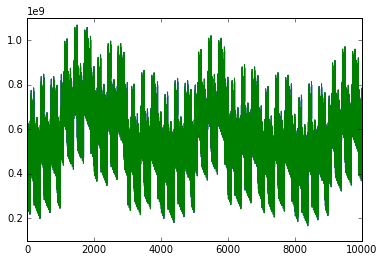

In [27]:
plt.plot(np.arange(0, 10000), output_costs)
plt.show()